## Analysis code for 'Are colour experiences the same across the visual field?'
### Pre-registration code
Written by Ariel Zeleznikow-Johnston, 2021
ariel.zeleznikow-johnston@monash.edu  
Github link to experiment: https://github.com/ArielZJ/SimilarityColorProject-MultiplePatches  
Github link to this analysis code: https://github.com/ArielZJ/Precision-Phenomenology-Data-Analysis

### Initialisations

In [3]:
filename = "data/pilotcompiled.csv"
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later

In [4]:
# various parameters
stimuli_number = 9
response_type_list = c('during')
trial_types = c('during')
response_names = c('During')
catch_trial_number = 10 # what it's set at at the moment, arbitrary
condition_number = 3
max.DSR = 7
min.DSR = 0

In [5]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 600 # mean reaction times must be above this
score_cutoff=0.7

In [6]:
exclude_noncompliant = FALSE

In [7]:
# colors for the labels
# changed for this mixed version
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA")
abcolors <- sort(colors)

eccens.colors <- c(
    'Central #FF0000',
    'Central #FFAA00',
    'Central #AAFF00',
    'Central #00FF00',
    'Central #00FFA9',
    "Central #00A9FF",
    'Central #0000FF',
    'Central #AA00FF',
    "Central #FF00AA",
    'Peripheral #FF0000',
    'Peripheral #FFAA00',
    'Peripheral #AAFF00',
    'Peripheral #00FF00',
    'Peripheral #00FFA9',
    "Peripheral #00A9FF",
    'Peripheral #0000FF',
    'Peripheral #AA00FF',
    "Peripheral #FF00AA")

inverted.colors <-  c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')

### Initialisations

In [8]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [9]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)
#library(fclust)
library(plot.matrix)
#library(gtools)
library(stringi)
#library(Bolstad)
library(olsrr) # for checking violation of regression assumptions
library(lmtest) # for likelihood ratio test
library(car) # for logistic transformation
library(betareg) # beta regressions
library(coin) # wilcox power analyses
library(rstatix) # power analyses

In [106]:
# getting bayesbr to do the bayesian analysis
library(bayesbr)
library(BayesFactor)
library(brms)

Loading required package: Rcpp
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 
Loading 'brms' package (version 2.15.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: 'brms'

The following object is masked from 'package:survival':

    kidney

The following object is masked from 'package:stats':

    ar



### Functions we're going to use to do the analysis later

#### Miscellaneous

In [11]:
# check our N 
get_n <- function(datadf){
    n <- length(unique(datadf$subject))
    print(paste("There are",n,"unique subjects"))
    return(n)
}

In [12]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Central'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Central'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Central')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Central'){
        return(-1)
    } else {
        return(1)
    }
}

In [13]:
get.submat <- function(mat,submat){
    if(submat == 'CC'){
        out.mat <- mat[1:9,1:9]
    } else if (submat == 'CP'){
        out.mat <- mat[1:9,10:18]
    } else if (submat == 'PP'){
        out.mat <- mat[10:18,10:18]
    }
    return(out.mat)
}

#### Dissimilarity Matrices

In [14]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
# doesn't care whether this comes from individual subjects or whole populations
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (Central, Central)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [15]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [16]:
# plot a shuffled dissimilarity matrix, for visualisation purposes only
dissimplot_shuffled <- function(datadf){
    # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    datadf$similarity = sample(datadf$similarity, replace=FALSE) # shuffle colour 2
    
     plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste("SHUFFLED\n",label1, " - ", label2)) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [17]:
# making a matrix symmetric. Borrowed from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not a square matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

In [18]:
# CLEAN THIS UP
# obtain dissimilarity dataframe that corresponds to all of a subject's judgements
# symmeterises XY & YX by taking the mean if asked
dissimdata.subject <- function(datadf, colors=colors, duplicate=TRUE, symmeterise=TRUE, diagnose=FALSE){
    
    if(diagnose){print(paste("Duplicate:",duplicate,"Symmetrise:", symmeterise))}
    
    # first, get a full label for each trial
    datadf <- subset(datadf, trial_type != 'catch')
    
    if(symmeterise){
        
        if(diagnose){print(paste("Initiate symmeterisation"))}
        
        datadf <- datadf %>%
        rowwise() %>%
        mutate(color.eccen1 = paste(c(e2l(Circle_1),Color_1),collapse=' - ')) %>%
        mutate(color.eccen2 = paste(c(e2l(Circle_2),Color_2),collapse=' - ')) %>%
        mutate(color.eccen = paste(sort(c(e2l(Circle_1),Color_1,e2l(Circle_2),Color_2)),collapse=':')) %>%
        ungroup()

        # take the average across symmetric trials (e.g. C-blue, P-green & C-green, P-blue)

        datadf <- aggregate(datadf, by = list(datadf$color.eccen),mean)
        datadf$color.eccen <- datadf$Group.1 

        # get some labels back for plotting below that we destroyed in the process
        datadf$color.eccen.sacrifice <- datadf$color.eccen

        datadf <- datadf %>% separate(color.eccen.sacrifice, c("color.1","color.2","eccen.1","eccen.2"),':')



        datadf$color1.eccen1 <- paste(datadf$eccen.1,datadf$color.1)
        datadf$color2.eccen2 <- paste(datadf$eccen.2,datadf$color.2)
    }
    
    # duplicate some rows if we want to plot a full matrix - for aesthetic reasons
    # I'm sorry for how ugly this is but I had so many bugs making it for unfathomable reasons (to me) that I'm not
    # going to change it now. Feel free to clean it up for me
    if(duplicate){
        if(diagnose){print(paste("Initiate CP/PC duplication"))}
        tempdf <- subset(datadf,(color.1 != color.2))
        
        tempdf$color1.eccen1.temp <- tempdf$color1.eccen1
        tempdf$color2.eccen2.temp <- tempdf$color2.eccen2

        tempdf$color1.eccen1 <- tempdf$color2.eccen2.temp
        tempdf$color2.eccen2 <- tempdf$color1.eccen1.temp
             
        
        tempdf <- subset(tempdf, select = -c(color1.eccen1.temp, color2.eccen2.temp))
        
        tempdf2 <- subset(tempdf, substr(tempdf$color.eccen, 16, nchar(tempdf$color.eccen)) == ':Central:Peripheral')
        
        tempdf <- subset(tempdf, substr(tempdf$color.eccen, 16, nchar(tempdf$color.eccen)) != ':Central:Peripheral')
        
        tempdf2$temp1 <- tempdf2$color1.eccen1
        tempdf2$color1.eccen1 <- paste('Central',substr(tempdf2$temp1,nchar(tempdf2$temp1)-7+1,nchar(tempdf2$temp1)))
        tempdf2$temp2 <- tempdf2$color2.eccen2
        tempdf2$color2.eccen2 <- paste('Peripheral',substr(tempdf2$temp2,nchar(tempdf2$temp2)-7+1,nchar(tempdf2$temp2)))
        debug <- subset(tempdf2, select=c(color1.eccen1,temp1,color2.eccen2,temp2))
        tempdf2 <- subset(tempdf2, select = -c(temp1,temp2))
        
        
        datadf <- rbind(datadf,tempdf,tempdf2)
        
    
        datadf$color <- substr(datadf$color.eccen, 1, 15) # get a colour pair label
        datadf$color1 <- substr(datadf$color, 1, 7)
        datadf$color2 <- substr(datadf$color, 9, 15)
    } else {
        datadf$Circle_1[datadf$Circle_1 == -1] <- 'Central'
        datadf$Circle_2[datadf$Circle_2 == -1] <- 'Central'
        datadf$Circle_1[datadf$Circle_1 == 1] <- 'Peripheral'
        datadf$Circle_2[datadf$Circle_2 == 1] <- 'Peripheral'
        datadf$color1.eccen1 <- paste(datadf$Circle_1,datadf$Color_1,sep=' ')
        datadf$color2.eccen2 <- paste(datadf$Circle_2,datadf$Color_2,sep=' ')

    }
    
    # refactor the levels so they can be plotted properly later if need be
       datadf$color1.eccen1 <- with(datadf, factor(color1.eccen1, levels = eccens.colors))
       datadf$color2.eccen2 <- with(datadf, factor(color2.eccen2, levels = eccens.colors))
    if(diagnose){print(paste("Subject trial number:", nrow(datadf)))}
     
    
    #print(datadf$color1.eccen1)
    return(datadf)
}

In [19]:
# convert a df to a group of subject matrices
dissimgroup2matlist <- function(df){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    mat.list <- list()
    k = 1
    for(ID in subjectlist){
        subjectdf <- subset(df, subject == ID)
        subject.mat <- color.eccen.mat(dissimdata.subject(subjectdf), output='matrix')
        mat.list[[k]] <- subject.mat
        k = k + 1
    }
    return(mat.list)
} 

In [20]:
# convert a groups of matrices to a group average matrix
group.mat.average <- function(mat.list){
    # average the matrices
    mat.average <- Reduce('+',mat.list)/length(mat.list)
    return(mat.average)
}
   

In [21]:
# make a dissimilarity plot for a group of subjects
group.dissim <- function(df){
    mats <- dissimgroup2matlist(df)
    avg.mat <- group.mat.average(mats)
    
    data <- melt(avg.mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','similarity')
    return(data)
    
    
}




In [22]:
# label the rows with the two colours independent of arbitrary ordering
dissimplot.full <- function(datadf, mode='standard',rotation=90,dependent='dissimilarity'){
        
    if(dependent=='RT'){
        #datadf$similarity <- log10(datadf$similarity)
    }
    
    plot <- ggplot(datadf, aes(x = color1.eccen1, y = color2.eccen2)) 
    
    if(mode=='standard'){
        color.list <- c(colors,colors)
    } else if (mode=='inversion'){
        color.list <- c(colors, inverted.colors)
    } else if (mode == 'rotation'){
        color.list <- c(colors, rotate.vec(colors,rotation))
    }
    plot <- plot + theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    
    
    # dissimilarity plot
    if(dependent=='dissimilarity'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"),
                                    limits=c(0,7),
                                    breaks=c(0,1,2,3,4,5,6,7)) +
                guides(fill=guide_legend(title="Dissimilarity"))
    }
    # reaction time plot
    if(dependent=='RT'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"), trans = "log",
                                    #limits=c(1000,1600),
                                    #limits=c(2.9,3.3),
                                    #breaks=c(2.9,3,3.146,3.255,3.3),
                                     limits = c(800,2000),
                                    breaks=c(800,1000,1400,1800),
                                    labels=c(800,1000,1400,1800)
                                    ) +
                guides(fill=guide_legend(title="RT (log)"))
    }
    # variance plot
    if(dependent=='variance'){
        
    }
    return(plot)
    
}

In [23]:
# convert a dataframe to a matrix. Automatically symmeterises the data. Only works on submatrices
df2mat.full <- function(datadf,eccentricity1=l2e('Central'),eccentricity2=l2e('Central')){
 
    # select only the eccentricities we want to keep, e.g. (Central, Central)
    datadf <- subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)

    # aggregate over the remaining columns of interest
    datadf <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    datadf$Color_1 <- datadf$Group.1
    datadf$Color_2 <- datadf$Group.2

    datadf = subset(datadf, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
    datadf <- spread(datadf, Color_1, similarity)
    
    # convert the dataframe to a matrix
    datamatrix <- data.matrix(datadf)
    datamatrix <- datamatrix[,-1] # get rid of the labels in the first column, it messes up the code
    datamatrix <- make.symmetric(datamatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    rownames(datamatrix) <- colnames(datamatrix)
    
    # sort the matrix
    datamatrix <- datamatrix[, sort(colnames(datamatrix))][sort(rownames(datamatrix)),]
    
    return(datamatrix)
    
}

In [24]:
# variance plot
variance.plot <- function(mat,
                         col1='blue',col2='yellow',na.col='green',
                                  legend.title='Variance',
                                  xlabel='',ylabel='',
                                  low.lim=0,up.lim=10){
    if(ncol(mat)<10){
        color.list <- colors
    } else {
        color.list <- c(colors,colors)
    }
    longData <- melt(mat)
    
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,up.lim),
                        na.value=na.col) + 
    theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))

    return(plot)
}
    

In [25]:
# convert a dataframe to a matrix v2, with some added functionality and without automatic
# symmeterisation
color.eccen.mat <- function(datadf,output='DF',mode='identity',rotation=90,plot=FALSE,dependent='dissimilarity',
                           duplicate=TRUE){
    library('plot.matrix')
    if(dependent=='RT'){
        datadf$similarity <- datadf$response_time
    }
    data <- subset(datadf, select = c(color1.eccen1, color2.eccen2, similarity))
    data <- spread(data, color1.eccen1, similarity)
    row.names <- data$color2.eccen2
    data.mat <- data.matrix(data)
    rownames(data.mat) <- row.names
    data.mat <- data.mat[,-1] # get rid of the redundant first column
    
    # duplicate Central x Peripheral matrix
    # 1. Make this only if requested
    # 2. Shouldn't this be transposed?
    if(duplicate){
        PF <- data.mat[10:18, 1:9]
        data.mat[1:9,10:18] <- t(PF)
    }
    
    
    # perform a label swap
    peripheral.labels <- c(10:18)
    if(mode == 'random'){
        swap.vec <- sample(peripheral.labels) # pick a random ordering of the peripheral labels
    } else if (mode == 'rotate'){
        swap.vec <- rotate.vec(peripheral.labels,rotation=rotation)
    } else if (mode == 'invert'){
        swap.vec <- match(inverted.colors,colors) + 9
    }
    if(mode != 'identity'){ # do the swap
        data.mat[10:18,] <- data.mat[swap.vec, ] # reorder the rows
        data.mat[,10:18] <- data.mat[, swap.vec] # reorder the columns
    }
        
    
    # plot the data
    if(plot){
        plot(data.mat, col=gray.colors(8, start=0, end=1, gamma=0.75, rev=TRUE),
         xlab = 'Fovea                                      Periphery',
        ylab = 'Fovea                                      Periphery')
    }
    
    
    # choose output type
    if(output == 'DF'){
        data <- as.data.frame(as.table(data.mat))
        colnames(data) <- c("color1.eccen1","color2.eccen2","similarity")
        return(data)
    } else if (output == 'matrix'){
        return(data.mat)
    }
}

In [26]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Central'))
    fpmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    cc <- sum(diag(fmatrix))/nrow(fmatrix)
    cp <- sum(diag(fpmatrix))/nrow(fpmatrix)
    pp <- sum(diag(pmatrix))/nrow(pmatrix)
    
    
    return(list(cc,cp,pp))
}

In [27]:
# obtains a dataframe of traces for subjects
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),
                          fftrace=double(),
                          fptrace=double(),
                          pptrace=double(),
                         stim_size=double(),
                         magnification=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        subject_trace <- trace_avg(tempdf)
        stim <- unique(tempdf$stimulus_radius)[1]
        mag <- unique(tempdf$peripheral_scale)[1]
        row_df <- data.frame(ID, as.numeric(subject_trace[1]),
                             as.numeric(subject_trace[2]),
                             as.numeric(subject_trace[3]),
                            stim,mag)
        names(row_df) <- c("subject","CC",'CP',"PP",'StimSize','Magnification')
        tracedf<- rbind(tracedf,row_df)
    }
    return(tracedf)
}

In [28]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [29]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [30]:
# calculate the catch trial score for a subject
catch_score <- function(datadf){
    datadf <- subset(datadf, trial_type == 'catch')
    datadf$correct <- ifelse(as.character(datadf$similarity) == as.character(datadf$catch_vals), 1, 0) # determine whether they got the catch trials right
    score <- sum(datadf$correct)/nrow(datadf) # get the score
    return(score)
}

In [31]:
# catch trial checker
catch_trial_checker <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Catch scores")
    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid)
        
        catch_trials <- subset(subjectdf, trial_type == 'catch')
        catch_num = nrow(catch_trials)
        catch_correct = nrow(subset(catch_trials, as.character(catch_vals) == as.character(similarity))) # had to add the as.character to block a bug, don't know why
        
        print(paste("Subject",subjectid,":",catch_correct,"/",catch_num))
    }
}

In [32]:
# screen parameters
screen_parameters <- function(datadf,individual=FALSE){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Screen Parameters")
    screen_fail = 0
    viewing_fail = 0
    for (subjectid in subjectlist){

        subjectdf = subset(datadf, subject == subjectid)
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        
        if(screen_size < 20){screen_fail = screen_fail + 1}
        if(viewing_distance < 30){viewing_fail = viewing_fail + 1}
        
        if(individual){
            print(paste("Subject",subjectid,":"))
            print(paste("Screen size:",screen_size,"cm"))
            print(paste("Viewing distance:",viewing_distance,"cm"))
            print("")
        }
        
        
    }
    print("")
    print(paste("Screen size issues:",screen_fail,"/",length(subjectlist)))
    print(paste("Viewing distance issues:",viewing_fail,"/",length(subjectlist)))
}

#### Multidimensional Scaling Plots

In [33]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Non-metric multidimensional scaling (NMDS)

In [34]:
# find the nmds fit for a dataset
nmdsfit <- function(distmatrix){
      
    fit <- isoMDS(distmatrix,k=2, maxit=100)
    return(fit)
}

In [35]:
# plot the nmds fit
nmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = points.1, y = points.2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Non-metric MDS',sep=' - '))
    return(plot)
}

Classical multidimensional scaling

In [36]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [37]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [38]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = similarity)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf,QDM='FULL'){
    
    if(QDM == 'FP'){
        datadf <- subset(datadf, ((Circle_1 == l2e('Central') & Circle_2 == l2e('Peripheral')) |
                                 (Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Central'))
                                 ))
    }
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = similarity)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = paste(QDM,'Dissimilarity')) +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [39]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time)) + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    stat_summary(fun.y = mean, geom = "line", size=2.5, aes(group=1)) + # add a population summary
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [40]:
# mean reaction time vs. catch trial score
rt_catch <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_catch_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- rt_catch(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=response_time, y=catch_score)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')+ xlim(0,5000)
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) + # linear line of best fit
            geom_hline(yintercept=score_cutoff, linetype = 'dashed', color='red') +
            geom_vline(xintercept=rt_cutoff, linetype = 'dashed', color='blue')
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    return(plot)
}

In [41]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

#### Check their screen size & viewing distance

In [42]:
# screen size in mm
screen_size <- function(datadf){
    
    datadf <- subset(datadf, trialcode == 'centermouse') # make sure calibrations have finished first
    
    width <- as.numeric(substr(as.character(datadf$screen_size_x)[1],1,6))
    height <- as.numeric(substr(as.character(datadf$screen_size_y)[1],1,6))
    
    # use pythagoras to just get the hypotenuse. Subjects have a fixed 16/9 aspect ratio so these are all comparable
    return(sqrt(width*width + height*height))
}

In [43]:
# viewing distance in mm
view_distance <- function(datadf){
    return(as.numeric(substr(as.character(datadf$viewer_distance)[1],1,6)))
}

In [44]:
# get a list of subject matrices based on conditions
subject.mats <- function(df,scaling,radius){
    subset.df <- subset(df, peripheral_scale == scaling & stimulus_radius == radius)
    group.mats <- dissimgroup2matlist(subset.df)
    return(group.mats)
}

In [45]:
#test <- subject.mats(cleandf,1,1)

In [46]:
# turn a list of full matrices into difference submatrices (e.g. CC - CP)
difference.mats <- function(subject.mats,submat='CCvPP',shuffle=FALSE){
    
    mat.list <- list()
    k = 1
    for(i in 1:length(subject.mats)){
        mat <- subject.mats[[i]]
        CC.mat <- mat[1:9,1:9]
        CP.mat <- mat[1:9,10:18]
        PP.mat <- mat[10:18,10:18]
        
        if(shuffle){
            CC.mat <- shuffle_matrix(CC.mat)
            CP.mat <- shuffle_matrix(CP.mat)
            PP.mat <- shuffle_matrix(PP.mat)
        }
        
        if(submat == 'CCvPP'){
            out.mat <- CC.mat - PP.mat
            colnames(out.mat) <- colnames(PP.mat)
        } else if (submat=='CPvPP'){
            out.mat <- CP.mat - PP.mat
            colnames(out.mat) <- colnames(PP.mat)
        } else if (submat=='CCvCP'){
            out.mat <- CC.mat - CP.mat
            colnames(out.mat) <- colnames(CP.mat)
        }
        
        mat.list[[k]] <- out.mat
        k = k + 1
    }
    return(mat.list)
}


In [47]:
# plot for a group of difference matrices
mat.summary.plot <- function(mat,reverse=TRUE,
                                 col1='blue',col2='orange',na.col='purple',
                                  legend.title='value',overall.title='',
                                  xlabel='CC?',
                                  ylabel='PP?',
                                  low.lim=-2,up.lim=2){
   
    
    # convert to df for plotting purposes
    if(reverse){
        mat <- mat[nrow(mat):1,]
    }
    longData <- melt(mat)
    
    # plot
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,0,up.lim),
                        na.value=na.col) +
    ggtitle(overall.title) + xlab(xlabel) + ylab(ylabel) + theme(axis.text.x = element_text(angle=90, vjust =0.5,hjust=1))

    return(plot)
    
}

In [48]:
#mat.summary.plot(group.mat.average(difference.mats(test)))               # mean plot for a group of difference matrices
#mat.summary.plot(mat.variance(difference.mats(test)),low.lim=0,up.lim=7) # variance plot for a group of difference matrices

In [49]:
# histogram plot for a cell in a difference matrix
cell.hist.plot <- function(v, color1, color2){
    df <- data.frame(v)
    
    plot <- ggplot(df, aes(x=v)) + geom_histogram(binwidth=1) + ggtitle(paste(color1,color2)) +
            xlim(-8,8) + ylim(0,length(v))

    return(plot)
}

In [50]:
# plot a sequence of histograms for each cell in a group matrix
mat.hist.plot <- function(group.mat, diagnose=FALSE,vals=FALSE){
    n.cells <- length(group.mat[[1]])
    n.subjects <- length(group.mat)
    n.qualia <- nrow(group.mat[[1]])
    
    if(diagnose){
        print(paste('n.cells',n.cells))
        print(paste('n.subjects',n.subjects))
        print(paste('n.qualia',n.qualia))
    }
    
    plot.list <- list()
    k=1
    vals.list <- list()
    
    for(cell in 1:n.cells){
        v <- vector()
        for(subject in 1:n.subjects){
            v <- c(v,group.mat[[subject]][cell])
        }
        if(vals){
            vals.list[[cell]] <- v
        } else{
            plot <- cell.hist.plot(v, 
                               rownames(group.mat[[1]])[floor((cell-1)/n.qualia)+1],
                               colnames(group.mat[[1]])[((cell-1)%%(n.qualia)) + 1])
            plot.list[[k]] <- as.grob(plot)
        }
        
        k = k + 1
        if(diagnose){
            print(paste('k',k))
        }
    }
    
    if(vals){
        return(vals.list)
    }
    
    g <- arrangeGrob(grobs = plot.list, ncol = n.qualia, nrow = n.qualia)
    ggsave(paste('demo','.png',sep=''),g,height=49,width=49)
}

In [51]:
#test.mat <- (difference.mats(test))
#mat.hist.plot(test.mat)
#test.vals <- mat.hist.plot(test.mat,vals=FALSE)
#test.vals

## Preprocessing

#### Loading the data

In [52]:
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later


#### Cleaning the data as per the exclusion criteria

In [53]:
# CLEAN THIS UP
#weird bug in a subject data for arielzj_fvp_2stim_fixed_point25dva_v2_20_08_30 (1)
datadf <- subset(datadf, (subject != 660294531) & (subject != 21721408) & (subject != 238973028))

In [54]:
# remove practice trial data
datadf <- subset(datadf, blockcode == 'experiment')

In [55]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))



In [56]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
Central = -1
peripheral = 1

In [57]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(eccen_type = case_when(Circle_1 == l2e('Central') & Circle_2 == l2e('Central') ~ 'CC',
                             Circle_1 == l2e('Central') & Circle_2 == l2e('Peripheral') ~ 'CP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'CP'))
    return(datadf)
}

In [58]:
datadf <- label_eccen_type(datadf)

Some actual data cleaning

In [59]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    print(paste(length(subjectlist),"in dataset"))
    print("")
    
    for (ID in subjectlist){ # go through subject by subject
        
        trialnumber = stimuli_number*stimuli_number*condition_number + catch_trial_number
        
        trialsdone <- nrow(subset(datadf, subject == ID))
        print(paste("Subject",ID,"completed",trialsdone,"/",trialnumber))
        
        if ( trialsdone != trialnumber){ # see if they have the appropriate trial numbers
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [60]:
screen_parameters(datadf)

[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 191"
[1] "Viewing distance issues: 0 / 191"


In [61]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "191 in dataset"
[1] ""
[1] "Subject 3248455 completed 253 / 253"
[1] "Subject 9522584 completed 253 / 253"
[1] "Subject 11005010 completed 253 / 253"
[1] "Subject 13228849 completed 253 / 253"
[1] "Subject 35587329 completed 253 / 253"
[1] "Subject 35716339 completed 253 / 253"
[1] "Subject 40354804 completed 253 / 253"
[1] "Subject 41471776 completed 32 / 253"
[1] "Subject 48341337 completed 253 / 253"
[1] "Subject 50823202 completed 253 / 253"
[1] "Subject 51805023 completed 253 / 253"
[1] "Subject 53858324 completed 253 / 253"
[1] "Subject 63991259 completed 253 / 253"
[1] "Subject 64413254 completed 253 / 253"
[1] "Subject 74258126 completed 12 / 253"
[1] "Subject 75394365 completed 253 / 253"
[1] "Subject 80499026 completed 253 / 253"
[1] "Subject 81903961 completed 253 / 253"
[1] "Subject 95990930 completed 2 / 253"
[1] "Subject 98665966 completed 253 / 253"
[1] "Subject 99640956 completed 253 / 253"
[1] "Subject 107179842 completed 37 / 253"
[1] "Subject 120361401 completed

In [62]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,
                               screen_size_cutoff=26,viewing_distance_cutoff=30,rt_cutoff=800,score_cutoff=0.7){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        catch_score <- catch_score(subjectdf)
        
        if(catch_score > score_cutoff){ # catch score cutoff
            if(screen_size > screen_size_cutoff){ # screen size cutoff
                if(viewing_distance > viewing_distance_cutoff){ # viewing distance cutoff
                    if(rt_avg(subjectdf) > rt_cutoff){ # rt cutoff
                        datadf$noncompliant[datadf$subject == ID] = 0
                    } else {
                        print(paste("Subject",ID,"reaction time of:",rt_avg(subjectdf),"ms",sep=' ')) # RT fail
                        datadf$noncompliant[datadf$subject == ID] = 1
                    }
                } else {
                    print(paste("Subject",ID,"viewing distance of:",viewing_distance,"cm",sep=' ')) # Viewing distance fail
                    datadf$noncompliant[datadf$subject == ID] = 2
                }
            } else {
                print(paste("Subject",ID,"had a screen size of:",screen_size,"cm",sep=' ')) # Screen size fail
                datadf$noncompliant[datadf$subject == ID] = 3
            } 
      } else {
            print(paste("Subject",ID,"had a catch score of: ",catch_score,sep=' ')) # Catch score faile
            datadf$noncompliant[datadf$subject == ID] = 4
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [63]:
catch_trial_checker(datadf)

[1] "Catch scores"
[1] "Subject 3248455 : 10 / 10"
[1] "Subject 9522584 : 6 / 10"
[1] "Subject 11005010 : 10 / 10"
[1] "Subject 13228849 : 9 / 10"
[1] "Subject 35587329 : 10 / 10"
[1] "Subject 35716339 : 10 / 10"
[1] "Subject 40354804 : 10 / 10"
[1] "Subject 48341337 : 10 / 10"
[1] "Subject 50823202 : 10 / 10"
[1] "Subject 51805023 : 10 / 10"
[1] "Subject 53858324 : 9 / 10"
[1] "Subject 63991259 : 10 / 10"
[1] "Subject 64413254 : 10 / 10"
[1] "Subject 75394365 : 10 / 10"
[1] "Subject 80499026 : 10 / 10"
[1] "Subject 81903961 : 6 / 10"
[1] "Subject 98665966 : 10 / 10"
[1] "Subject 99640956 : 10 / 10"
[1] "Subject 120361401 : 1 / 10"
[1] "Subject 133207874 : 7 / 10"
[1] "Subject 147071530 : 7 / 10"
[1] "Subject 165762185 : 10 / 10"
[1] "Subject 170537732 : 10 / 10"
[1] "Subject 172093576 : 7 / 10"
[1] "Subject 176476116 : 10 / 10"
[1] "Subject 176698125 : 10 / 10"
[1] "Subject 204525930 : 10 / 10"
[1] "Subject 211745977 : 10 / 10"
[1] "Subject 219326440 : 7 / 10"
[1] "Subject 225280441 :

In [64]:
datadf <- label_noncompliant(datadf)

[1] "Subject 9522584 had a catch score of:  0.6"
[1] "Subject 48341337 reaction time of: 615 ms"
[1] "Subject 50823202 reaction time of: 753 ms"
[1] "Subject 80499026 reaction time of: 796 ms"
[1] "Subject 81903961 had a catch score of:  0.6"
[1] "Subject 98665966 reaction time of: 665 ms"
[1] "Subject 120361401 had a catch score of:  0.1"
[1] "Subject 133207874 had a catch score of:  0.7"
[1] "Subject 147071530 had a catch score of:  0.7"
[1] "Subject 172093576 had a catch score of:  0.7"
[1] "Subject 176698125 reaction time of: 755 ms"
[1] "Subject 211745977 reaction time of: 731 ms"
[1] "Subject 219326440 had a catch score of:  0.7"
[1] "Subject 244316230 had a catch score of:  0.5"
[1] "Subject 252347716 had a catch score of:  0.6"
[1] "Subject 254207207 had a catch score of:  0.4"
[1] "Subject 265310712 had a catch score of:  0.1"
[1] "Subject 285550479 had a catch score of:  0.1"
[1] "Subject 307922435 had a catch score of:  0.4"
[1] "Subject 369400829 had a catch score of:  0.7"

In [65]:
# function to run all these checks at once
validation <- function(datadf){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            print(paste("Magnification",scale,"Stimulus",stimulus))
            tempdf <- remove_incomplete(tempdf,stimuli_number)
            screen_parameters(tempdf, individual=FALSE)
            catch_trial_checker(tempdf)
            label_noncompliant(tempdf)
            print("")
            print("____________________")
            print("")
            
        }
    }
}

In [66]:
validation(datadf)

[1] "Magnification 1 Stimulus 0.05"
[1] "18 in dataset"
[1] ""
[1] "Subject 11005010 completed 253 / 253"
[1] "Subject 64413254 completed 253 / 253"
[1] "Subject 294207097 completed 253 / 253"
[1] "Subject 338738516 completed 253 / 253"
[1] "Subject 340691821 completed 253 / 253"
[1] "Subject 343319516 completed 253 / 253"
[1] "Subject 373678849 completed 253 / 253"
[1] "Subject 376591610 completed 253 / 253"
[1] "Subject 507377004 completed 253 / 253"
[1] "Subject 603387860 completed 253 / 253"
[1] "Subject 626450633 completed 253 / 253"
[1] "Subject 682309552 completed 253 / 253"
[1] "Subject 689093004 completed 253 / 253"
[1] "Subject 754276419 completed 253 / 253"
[1] "Subject 821695709 completed 253 / 253"
[1] "Subject 902494953 completed 253 / 253"
[1] "Subject 909015666 completed 253 / 253"
[1] "Subject 960528676 completed 253 / 253"
[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 18"
[1] "Viewing distance issues: 0 / 18"
[1] "Catch scores"
[1] "Subject 11005010 : 10

In [67]:
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 114 unique subjects"


[1] 114

Only using the smallest and largest stimuli for this analysis, so get rid of the other subject groups

In [68]:
cleandf <- subset(cleandf, (stimulus_radius == 1) | (stimulus_radius == 0.05))

## Descriptive Statistics

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


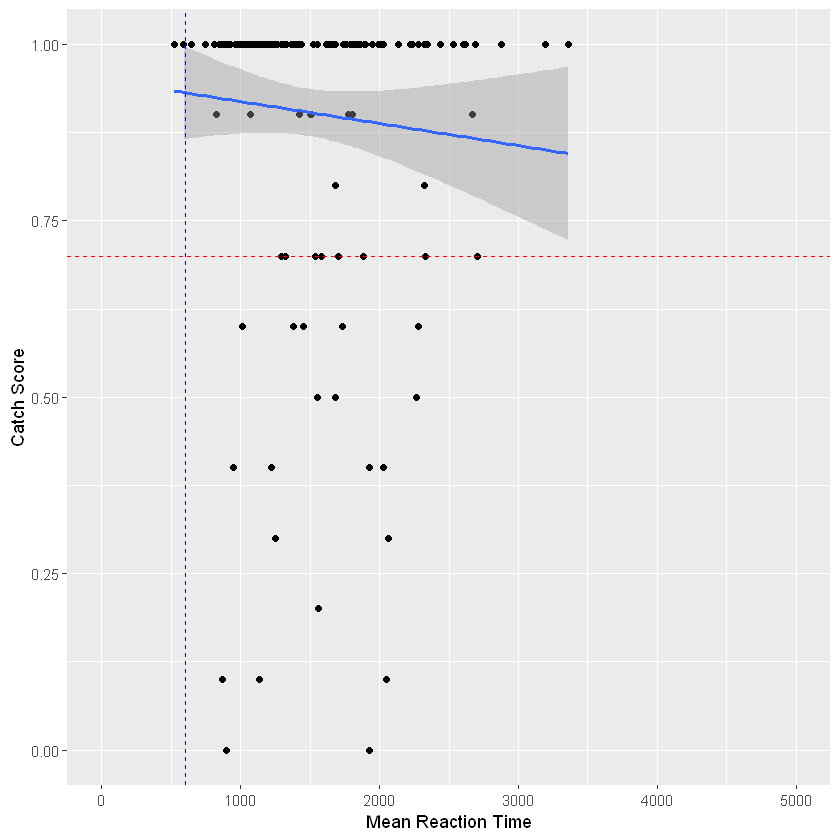

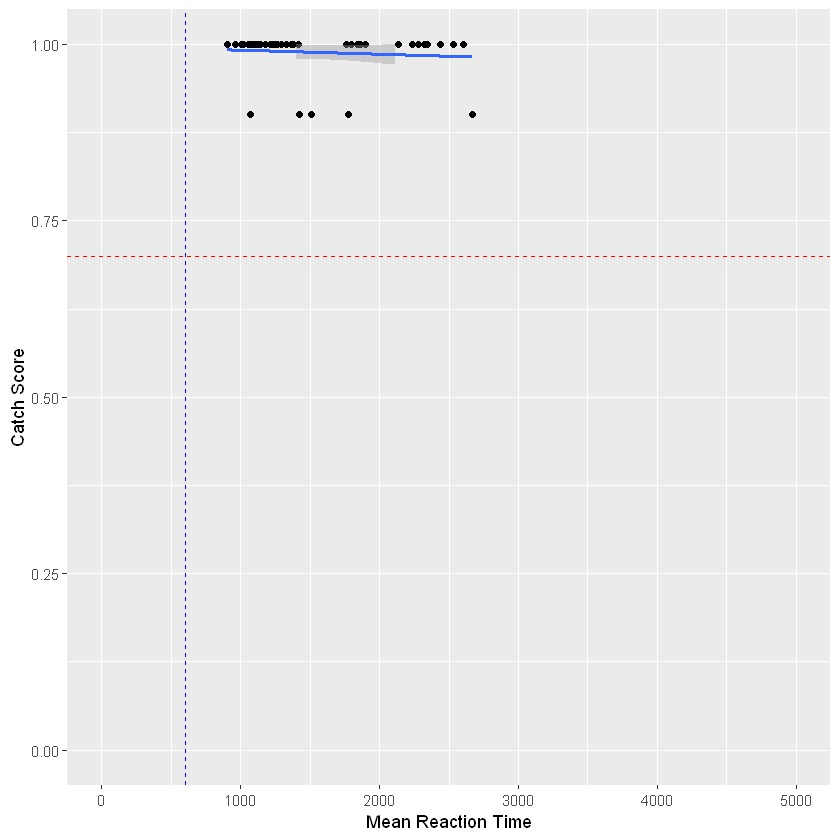

In [69]:
# Data quality check.

rt_catch_plot(datadf)
rt_catch_plot(cleandf)


In [70]:
# label the data for plotting
label <- function(df,raw=FALSE){
    if(raw){
        df$label.mag <- NA
        df$label.stim <- NA
        df$label.combo <- NA
        df$label.mag[df$peripheral_scale != 1] <- 'MAG'
        df$label.mag[df$peripheral_scale == 1] <- 'FIX'
        df$label.combo <- paste(df$label.mag, format(round(df$stimulus_radius,3),nsmall=2),'DVA')
    } else{
        df$label.mag <- NA
        df$label.stim <- NA
        df$label.combo <- NA
        df$label.mag[df$Magnification != 1] <- 'MAG'
        df$label.mag[df$Magnification == 1] <- 'FIX'
        df$label.combo <- paste(df$label.mag, format(round(df$StimSize,3),nsmall=2),'DVA')
    }
    
    return(df)
}

In [71]:
# make an MDS visualisation of each group
ds.mds <- function(df){
    
    # keep track of the plots
    plot.list <- list()
    k = 1
    
    # generate labels
    C <- c(rep('Central',9))
    P <- c(rep('Peripheral',9))
    Eccentricity <- c(C,P)
    colors2 <- c(colors,colors)
    
    scales <- unique(df$peripheral_scale)
    stims <- unique(df$stimulus_radius)
    for(scale in scales){
        for(stim in stims){
            mds.df <- subset(cleandf, peripheral_scale == scale & stimulus_radius == stim)
            mds.data <- dissimgroup2matlist(mds.df)
            mds.data <- group.mat.average(mds.data)
            mds.data <- mat2dist(mds.data)
            mds.data <- cmdsfit(mds.data)
            mds.data <- as.data.frame(mds.data)
            mds.data$Eccentricity <- Eccentricity
            
            # get label
            lab <- mds.df$label.combo[1]
            
            #mds plot
            plot <- ggplot(mds.data, aes(x = V1, y = V2, color=colors2)) + geom_point(size =10,aes(shape=Eccentricity)) + 
                #geom_text(aes(label=tags, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(lab) + 
                #theme(legend.position='none') +
                scale_colour_identity()
            plot.list[[k]] <- as.grob(plot)
            k = k + 1
            
            #dissimilarity data plot
            plot <- dissimplot.full(color.eccen.mat(dissimdata.subject(mds.df)),dependent='dissimilarity')
            plot.list[[k]] <- as.grob(plot)
            k = k + 1
        }
    }
    g <- arrangeGrob(grobs = plot.list, ncol=2, nrow=4)
    ggsave('descriptive_test.png',g,height=20,width=15)
    return(g)
}
cleandf <- label(cleandf,raw=TRUE)
ds.mds(cleandf)

TableGrob (4 x 2) "arrange": 8 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]
7 7 (4-4,1-1) arrange gtable[layout]
8 8 (4-4,2-2) arrange gtable[layout]

## Analysis Plan

### Visualisation of Hypothesis 1 Data

In [72]:
# plot the data
hyp1.plot <- function(df,histogram=FALSE){
    
    plot.df <- pivot_longer(data = trace.df, cols = c(CC,CP,PP), names_to = 'Comparison')
    print(colnames(plot.df)) # testing
    #plot.df$StimSize <- as.character(plot.df$StimSize)
    #plot.df$Magnification <- as.character(plot.df$Magnification)
    median <- median(subset(plot.df,Comparison=='PP')$value) # for connecting to hypothesis 1b
    
    plot <- ggplot(plot.df,aes(x = Comparison, y = value, 
                         #color = Magnification, 
                         #fill = StimSize
                         colour = label.combo
                                ),
                    size = 0.7) +
        geom_boxplot() +
        #scale_colour_manual(values = c("red","blue")) + 
        #scale_fill_manual(values = c("#E67E22","#1ABC9C"))
        geom_point(position=position_dodge(width=0.75)) +
        geom_hline(yintercept=3.5, linetype='dashed') +
        geom_hline(yintercept=median, linetype = 'dashed',color='blue') +
        ylim(0,7) +
        theme_bw(base_size = 14) +
        theme(legend.title=element_blank()) +
        xlab("") +
        #ylab("Normalised Trace") +
        scale_y_continuous(name='Normalised Trace',
                         breaks=c(0,1,2,3,4,5,6,7),
                         labels=c(0,1,2,3,4,5,6,7),
                         limits=c(0,7))
    
    if(histogram){
        plot.df <- subset(plot.df, Comparison=='PP')
        #print(plot.df)
        #plot.df$value <- logit((plot.df$value+0.33333)/7)
        hist.plot <- ggplot(plot.df, aes(x = value, fill=label.combo)) + geom_histogram(binwidth=0.3)
        return(hist.plot)
    }
    
    return(plot)
}

In [73]:
# obtain the data
trace.df <- trace_obtainer(cleandf)


In [74]:
trace.df <- label(trace.df)
head(trace.df)

subject,CC,CP,PP,StimSize,Magnification,label.mag,label.stim,label.combo
11005010,0.1111111,1.4444444,1.6666667,0.05,1.0,FIX,NA,FIX 0.05 DVA
53858324,0.7777778,1.8888889,0.8888889,0.05,4.5,MAG,NA,MAG 0.05 DVA
63991259,0.0000000,0.1111111,0.0000000,1.00,4.5,MAG,NA,MAG 1.00 DVA
64413254,0.3333333,0.8888889,2.1111111,0.05,1.0,FIX,NA,FIX 0.05 DVA
165762185,0.3333333,0.2222222,0.7777778,0.05,4.5,MAG,NA,MAG 0.05 DVA
170537732,1.0000000,1.4444444,1.1111111,0.05,4.5,MAG,NA,MAG 0.05 DVA


[1] "subject"       "StimSize"      "Magnification" "label.mag"    
[5] "label.stim"    "label.combo"   "Comparison"    "value"        


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


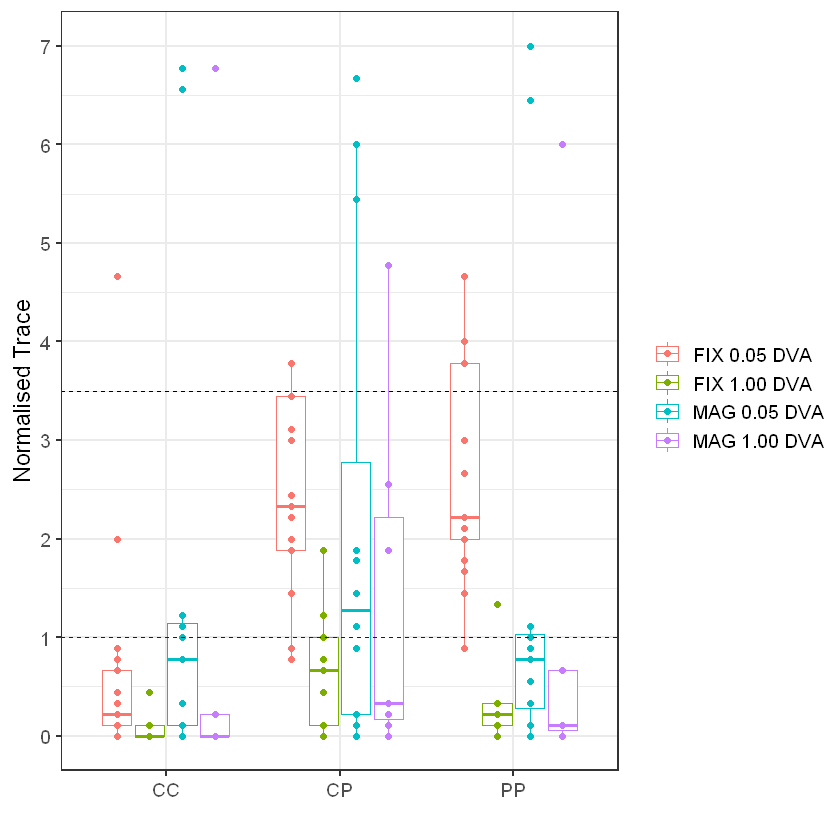

In [75]:
hyp1.plot(trace.df)

#### 1a) Do subjects respond that identical stimuli have zero dissimilarity when presented at each of CC, CP and PP?

For each subject, we obtained a dissimilarity value for the comparison of a colour stimulus to itself in each of the CC, CP and PP conditions. Are these dissimilarity values equal to zero, as would be expected? Is this true in all presentation conditions?  
  
If participants were randomly selecting these values, the mean dissimilarity across the colour pair comparisons would be mean of a random sample for the dissimilarity values. As these range from 0 to 7, this would be 3.5  
  
We will test to see if the mean dissimilarity for these values is less than 3.5 in data from subjects in the peripherally magnified conditions. We'll examine this for each of CC, CP and PP comparisons. Going to use a one-sample Wilcoxon signed rank test with Bonferroni corrections for multiple comparisons.

In [76]:
# obtain the relevant data
trace.df.mag <- subset(trace.df, Magnification != 1)
#head(trace.df)

In [77]:
wilcox_test(data=trace.df.mag, CC ~ 1, mu = 3.5, alternative = "less")
wilcox_effsize(data=trace.df.mag, CC ~ 1, mu = 3.5, alternative = "less")

.y.,group1,group2,n,statistic,p
CC,1,null model,19,25,0.0025


.y.,group1,group2,effsize,n,magnitude
CC,1,null model,0.6485549,19,large


In [78]:
# the trace test
trace.test <- function(v.trace,version='base'){
    if(version=='base'){
        test <- wilcox.test(v.trace, 
               alternative = "less",
              mu = 3.5,
              conf.int = TRUE,
              conf.level = 0.95)
    } else if(version=='coin'){
        test <- wilcox_test(v.trace ~ 1, mu=3.5)
    }
    
    return(test)
}

# test output formatter
test.format <- function(input,input.name,names){
    
    row_df <- data.frame(
                    input.name,
                    input$estimate,
                    input$statistic,
                    input$p.val,
                    input$conf.int[1],
                    input$conf.int[2])
    colnames(row_df) <- names
    return(row_df)
}

# test the relevant comparisons
trace.test.all <- function(df,diagnose=FALSE){
    
    # fix this up properly into a nice table please
    names <- c('Comparison','Median','Statistic','P.value','95% CI l','95% CI u')
   output <- data.frame(comparison=character(),
                     median.val=character(),
                     statistic=character(),
                     p.val=character(),
                     #effect.size=character(),
                     ci.low=character(),
                     ci.high=character())
    colnames(output) <- names
    
    # for each comparison
    CC.test <- test.format(trace.test(df$CC),'CC',names=names)
    CP.test <- test.format(trace.test(df$CP),'CP',names=names)
    PP.test <- test.format(trace.test(df$PP),'PP',names=names)
    
    if(diagnose){
        print(trace.test(df$CC))
        print(trace.test(df$CC))
        print(trace.test(df$CC))
    }
    
    output <- rbind(output,CC.test)
    output <- rbind(output,CP.test)
    output <- rbind(output,PP.test)
    
    # return the table
    return(output)
}

# make a pretty table to put the results into. Need to include:
# statistic (dof)
# p 
# effect size
# 95% CI

In [99]:
# One sample bayes factor analysis
bf = ttestBF(trace.df.mag$CC, mu = 3.5)
bf
#plot(posterior(bf, iterations=1000))

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 32.31851 ±0%

Against denominator:
  Null, mu = 3.5 
---
Bayes factor type: BFoneSample, JZS


In [79]:
trace.test.all(trace.df.mag,diagnose=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  v.trace
V = 25, p-value = 0.002502
alternative hypothesis: true location is less than 3.5
95 percent confidence interval:
     -Inf 3.277758
sample estimates:
(pseudo)median 
     0.5555431 


	Wilcoxon signed rank test with continuity correction

data:  v.trace
V = 25, p-value = 0.002502
alternative hypothesis: true location is less than 3.5
95 percent confidence interval:
     -Inf 3.277758
sample estimates:
(pseudo)median 
     0.5555431 


	Wilcoxon signed rank test with continuity correction

data:  v.trace
V = 25, p-value = 0.002502
alternative hypothesis: true location is less than 3.5
95 percent confidence interval:
     -Inf 3.277758
sample estimates:
(pseudo)median 
     0.5555431 



,Comparison,Median,Statistic,P.value,95% CI l,95% CI u
(pseudo)median,CC,0.5555431,25.0,0.002501874,-Inf,3.277758
(pseudo)median1,CP,1.3888861,29.0,0.004173121,-Inf,2.888883
(pseudo)median2,PP,0.6110846,29.5,0.004369244,-Inf,2.999978


#### 1b) Are dissimilarity ratings for identical stimuli presented in the periphery affected by peripheral magnification?

On the basis of previous psychophysics work we suspect that small stimuli in the periphery may induce altered or unstable colour experiences compared to larger stimuli. We also suspect that appropriately 'cortically magnified' stimuli should provide stable similarity judgments regardless of size. Thus, we hypothesise that there will be a Size x Magnification interaction effect on dissimilarity ratings made in the PP condition.  
  
As we are taking the average over non-negative values with a heavy preponderance of zeros, the data will be non-normally distributed. Thus, we are fitting the data using a GLM with a Poisson distribution and a **XXX** link.

In [80]:
# GLM method. Not sure if appropriate
# Deprecated
interaction.test <- function(data,diagnose=FALSE,link='identity',lr=FALSE){
    
     # testing
    data$PP <- logit((data$PP+0.33)/7) + 3.5
    print(data$PP)
    
    # do the test
    print(link)
    fit <- glm(formula = PP ~ StimSize + Magnification + StimSize*Magnification,
                family = Gamma(link="inverse"),
               data=data)
    print(summary(fit))
    print(confint(fit,level=0.95))
    if(diagnose){
        ols_plot_resid_qq(fit)
        print(ols_test_normality(fit))
        print(ols_test_correlation(fit))
    }
    if(lr){
        intercept.fit <- lm(formula = PP ~ 1,
                #family = poisson(link=link),
               data=data)
        print("Likelihood ratio test")
        lr.test <- lrtest(fit,intercept.fit)
        print(lr.test)
        return(lr.test)
    }
    return(fit)
}

Likelihood ratio test

Model 1: PP ~ StimSize * Magnification
Model 2: PP ~ 1
  #Df LogLik Df  Chisq Pr(>Chisq)   
1   5 31.976                        
2   2 24.869 -3 14.215   0.002627 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Call:
betareg(formula = PP ~ StimSize * Magnification, data = data)

Standardized weighted residuals 2:
    Min      1Q  Median      3Q     Max 
-2.2743 -0.3540 -0.0655  0.4114  2.9507 

Coefficients (mean model with logit link):
                       Estimate Std. Error z value Pr(>|z|)   
(Intercept)            -0.05203    0.34885  -0.149  0.88145   
StimSize               -1.89166    0.61658  -3.068  0.00216 **
Magnification          -0.24894    0.11934  -2.086  0.03698 * 
StimSize:Magnification  0.27689    0.19941   1.389  0.16496   

Phi coefficients (precision model with identity link):
      Estimate Std. Error z value Pr(>|z|)    
(phi)   2.6159     0.5354   4.886 1.03e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Type of estimator: ML (maximum likelihood)
Log-likelihood: 31.98 on 5 Df
Pseudo R-squared: 0.3116
Number of iterations: 17 (BFGS) + 2 (Fisher scoring) 

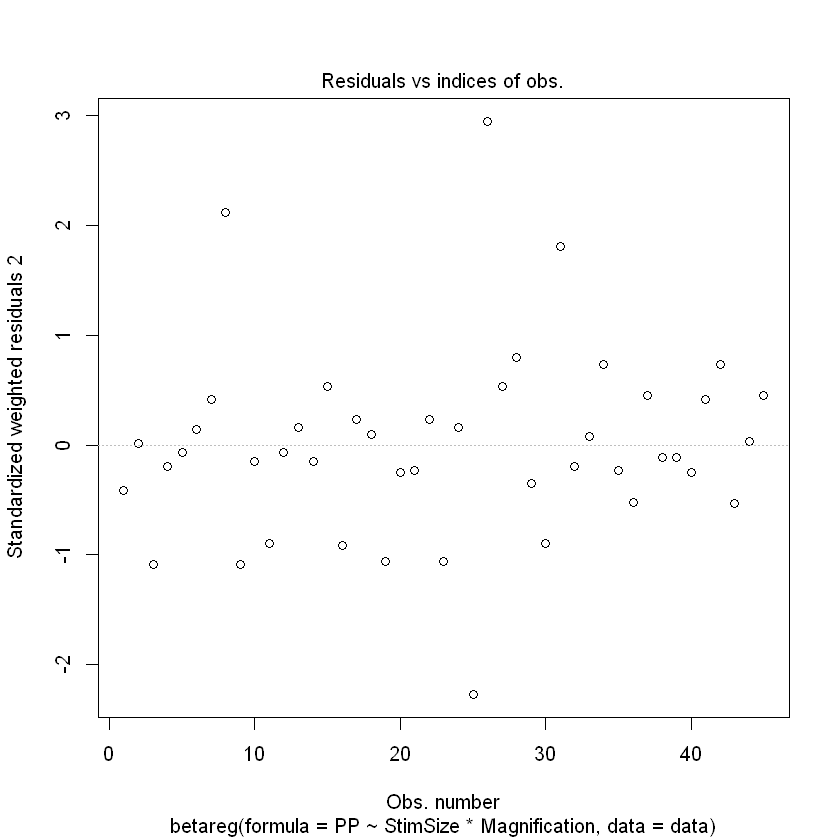

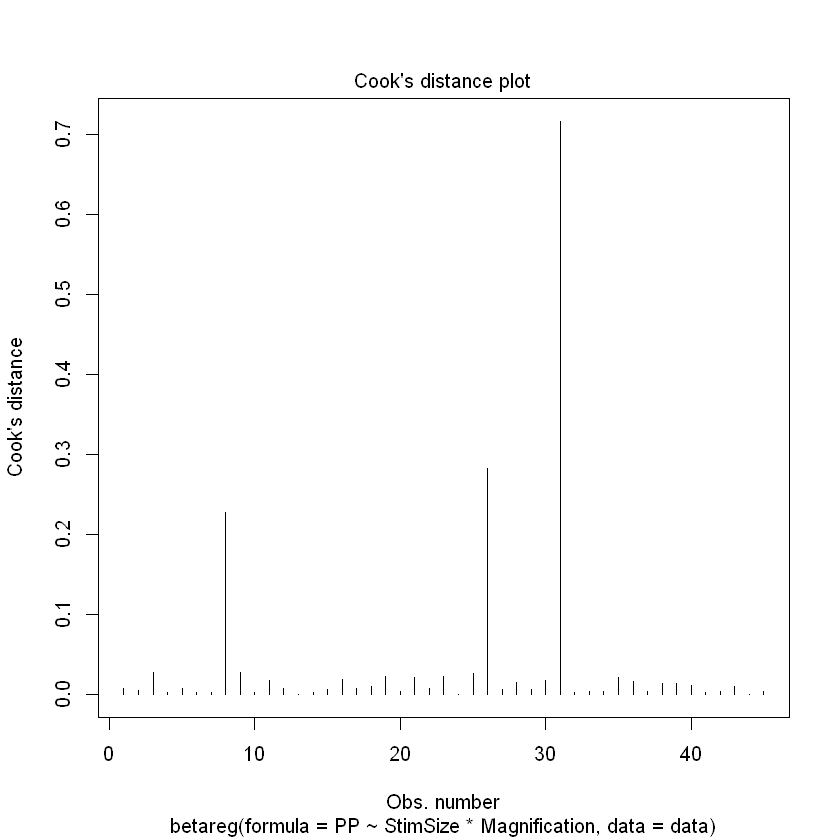

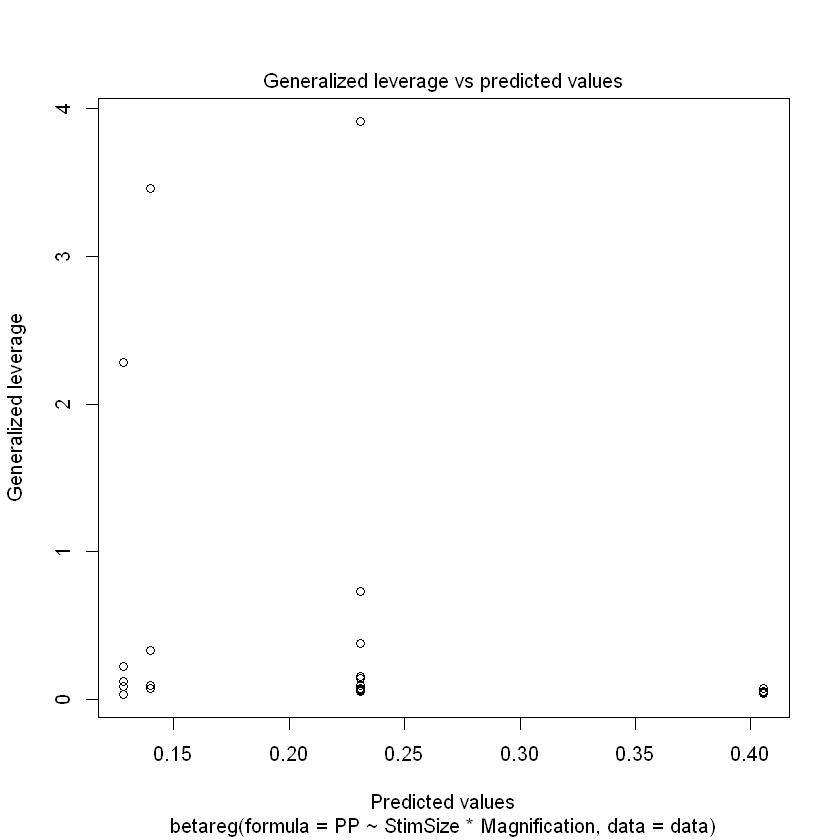

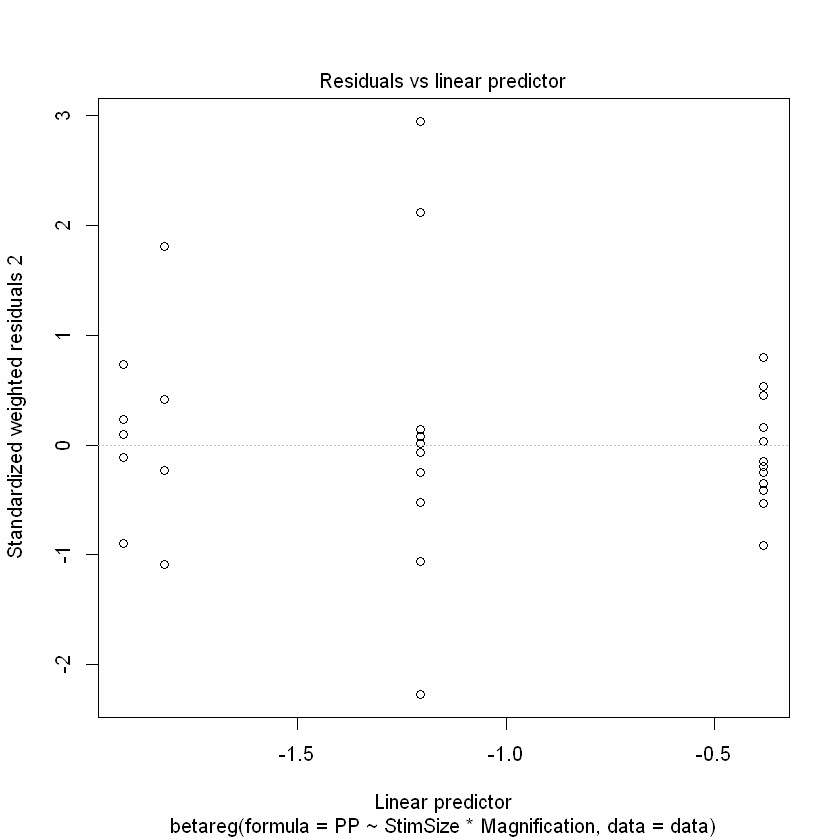

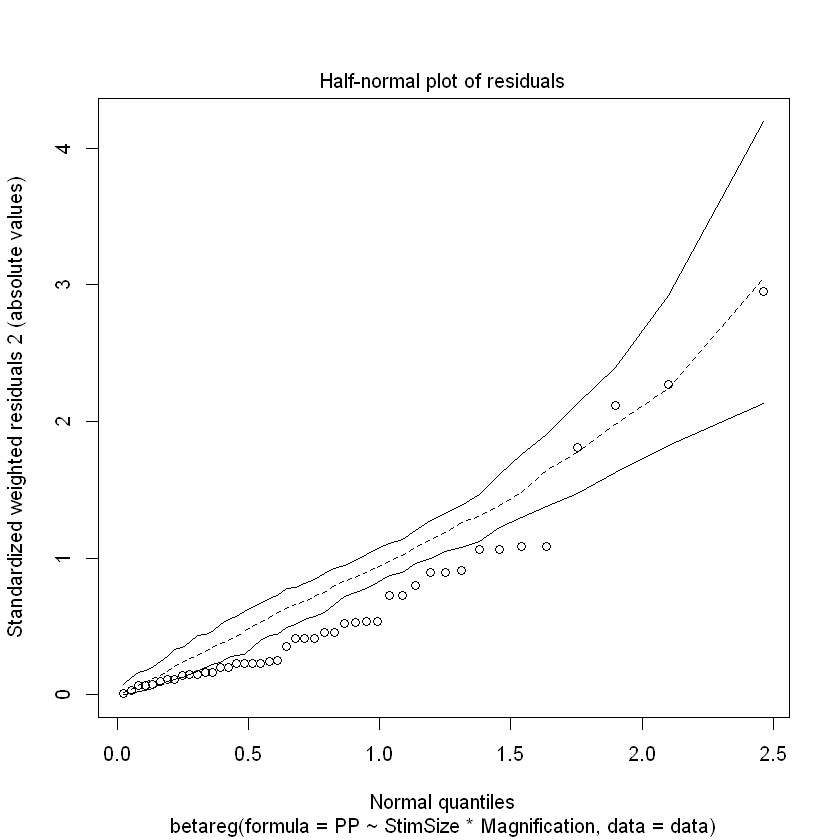

In [89]:
# Beta regression method - Nao's preferred tool
beta.test.fun <- function(data,lrtest=TRUE){
    
    # normalisation and boundary offset as suggested in Smithson and Verkuilen (2006)
    data$PP <- (data$PP * (length(data$PP)-1) + 0.5)/length(data$PP) # boundary offset
    data$PP <- data$PP/max.DSR
    #print(data$PP)
    
    beta.test <- betareg(formula = PP ~ StimSize*Magnification,
                    data = data)
    beta.null <- betareg(formula = PP ~ 1,
                        data = data)
    if(lrtest){
           print(lrtest(beta.test,beta.null))
    }
    return(beta.test)
}
test.beta <- beta.test.fun(trace.df)
summary(test.beta)
plot(test.beta, which=1:5)

In [107]:
# Bayesian version of the beta-regression, for sample analysis as well
beta.bayes <- function(data,interact=TRUE){
    
    # normalisation and boundary offset as suggested in Smithson and Verkuilen (2006)
    data$PP <- (data$PP * (length(data$PP)-1) + 0.5)/length(data$PP) # boundary offset
    data$PP <- data$PP/max.DSR
    
    # bayesian stuff
    if(interact){
        test <- bayesbr(formula = PP ~ StimSize*Magnification,
                    data = data)
    } else {
        test <- bayesbr(formula = PP ~ StimSize + Magnification,
                    data = data)
    }
    
    
    return(test)
}
test.bb.interact <- beta.bayes(rbind(trace.df,trace.df,trace.df))
test.bb.simple <- beta.bayes(rbind(trace.df,trace.df,trace.df), interact=FALSE)


SAMPLING FOR MODEL 'bayesbr' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 5.407 seconds (Warm-up)
Chain 1:                5.041 seconds (Sampling)
Chain 1:                10.

ERROR: Error: logml values need to be numeric


In [108]:
test.bb.simple
#bayes_factor(test.bb.interact,test.bb.simple)


Call:
bayesbr(formula = PP ~ StimSize + Magnification, data = data)


Coefficients (mean model): 
  (Intercept)       StimSize  Magnification  
     -0.26468       -1.25314       -0.13815  

Coefficients (precision model): 
 (phi)  
2.1763  

Number of Chains:  1 
Iter:  10000 
Warmup: 5000L 

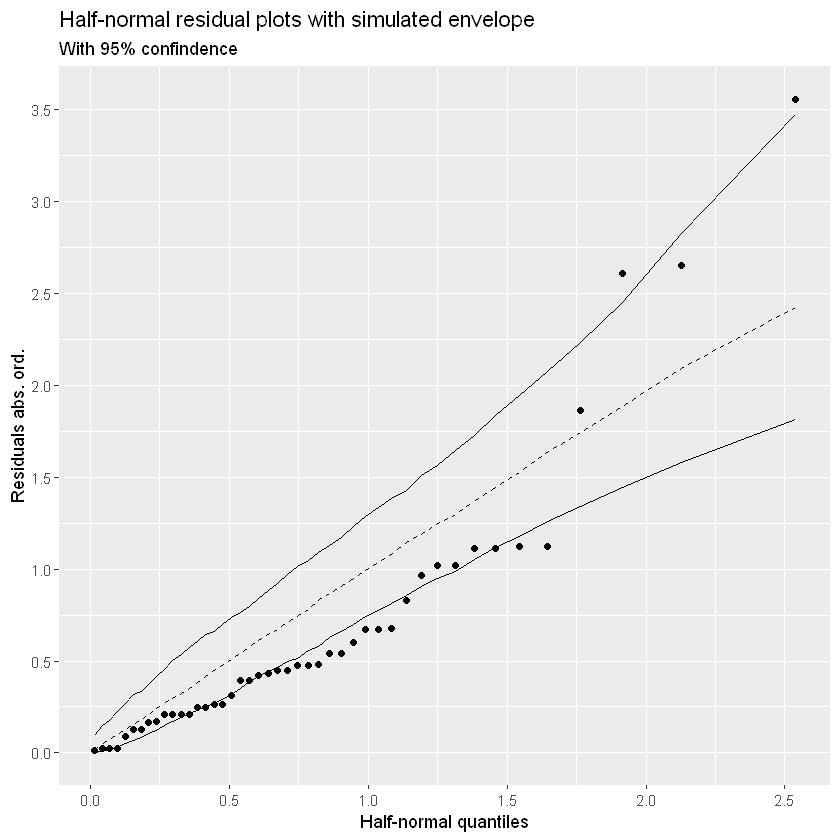

In [91]:
#loglikPlot(test.bb$loglik)
envelope(test.bb)

In [ ]:
# discretise & chi-square test method
# opted not to go with this
discrete.test <- function(data,hyp=1,mode='chi'){
    # find the median
    if(hyp==1){
        median <- median(data$PP)
        data$below.median[data$PP < median] <- 1
        data$below.median[data$PP >= median] <- 0
    }
    else if(hyp==2){
        median <- median(data$mean.var)
        print(median)
        data$below.median[data$mean.var < median] <- 1
        data$below.median[data$mean.var >= median] <- 0
    }
    
    
    # put the data in a matrix
    fix.small <- sum(subset(data, Magnification==1 & StimSize != 1)$below.median)
    fix.big <- sum(subset(data, Magnification==1 & StimSize == 1)$below.median)
    mag.small <- sum(subset(data, Magnification!=1 & StimSize != 1)$below.median)
    mag.big <- sum(subset(data, Magnification!=1 & StimSize == 1)$below.median)
    
    test.matrix <- matrix(c(fix.small,fix.big,mag.small,mag.big),2,2)
    colnames(test.matrix) <- c('Fixed','Magnified')
    rownames(test.matrix) <- c('Small','Big')
    
    print(test.matrix)
    
    if(mode=='exact'){
        test <- fisher.test(test.matrix,alternative='less')
    } else if(mode=='chi'){
        test <- chisq.test(test.matrix)
    }
    #
    print(summary(test))
    return(test)
}

In [175]:
#discrete.test(trace.df)
#discrete.test(trace.df,mode='exact')

In [176]:
#int.fit <- interaction.test(trace.df,diagnose=FALSE,lr=FALSE)
#interaction.test(trace.df,diagnose=FALSE,link='sqrt')
#interaction.test(trace.df,diagnose=FALSE,link='log')
#resid(int.fit,type='pearson')

### Visualisation of Hypothesis 2 Data

In [177]:
# get the variance of colour comparisons
var.color <- function(df,diagnose=FALSE){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(df, l2e('Central'), l2e('Central'))
    fpmatrix <- df2mat.full(df, l2e('Central'), l2e('Peripheral'))
    pmatrix <- df2mat.full(df, l2e('Peripheral'), l2e('Peripheral'))
    
    if(diagnose){
        #print(fmatrix)
    }
    
    # turn these into vectors
    ff.v <- fmatrix[upper.tri(fmatrix,diag=TRUE)]
    fp.v <- fpmatrix[upper.tri(fpmatrix,diag=TRUE)]
    pp.v <- pmatrix[upper.tri(pmatrix,diag=TRUE)]
    
    if(diagnose){
        #print(ff.v)
    }
    
    # calculate the variance for each colour
    colour.vars <- vector()
    for(i in 1:length(ff.v)){
        if(diagnose){
            #print(ff.v[i])
            #print(fp.v[i])
            #print(pp.v[i])
            #var(c(ff.v[i],fp.v[i],pp.v[i]))
        }
        colour.vars[i] <- var(c(ff.v[i],fp.v[i],pp.v[i]))
    }
    
    if(diagnose){
        print(colour.vars)
    }
    
    # get the mean variance
    var.mean <- mean(colour.vars)
    
    return(var.mean)
}

In [178]:
# get the data in the right format
var.format <- function(df){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    
    # format for output
    out.df <- data.frame(subject=character(),
                        mean.var=double(),
                        stim_size=double(),
                        magnification=double())
    # extract the data
    for(ID in subjectlist){
        tempdf <- subset(df, subject == ID)
        stim <- unique(tempdf$stimulus_radius)[1]
        mag <- unique(tempdf$peripheral_scale)[1]
        val <- var.color(tempdf)
        row_df <- data.frame(ID, val, stim, mag)
        names(row_df) <- c("subject",'mean.var','StimSize','Magnification')
        out.df <- rbind(out.df,row_df)
    }
    return(out.df)
}

In [179]:
# get the data we want
var.data <- var.format(cleandf)
#head(var.data)
var.data.mag <- subset(var.data, Magnification != 1)
# label the data
var.data <- label(var.data)

In [180]:
# simulating random selection
dis.v <- c(0:7)
rand.var <- mean(replicate(10000,var(sample(dis.v, 3, replace=TRUE))))
rand.var

[1] 5.328633

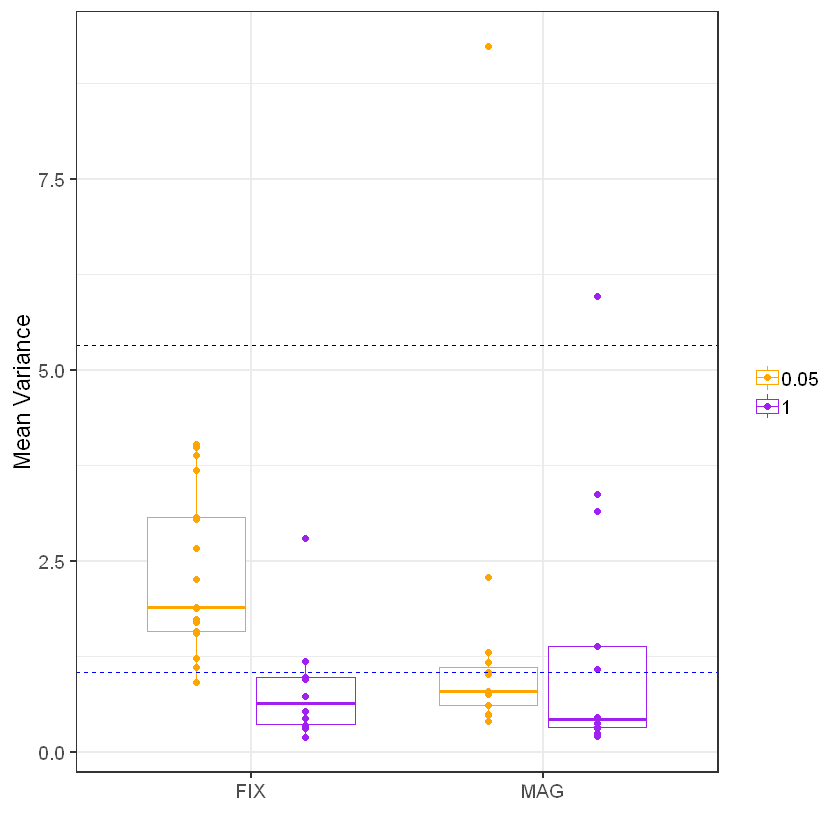

In [181]:
hyp2.plot <- function(plot.df,rand.var,histogram=FALSE){
    
    plot.df$StimSize <- as.character(plot.df$StimSize)
    plot.df$Magnification <- as.character(plot.df$Magnification)
    
    plot <- ggplot(plot.df) +
        geom_boxplot(aes(x = Magnification, y = mean.var, 
                         color = StimSize)) +
        geom_point(aes(x = Magnification, y = mean.var, 
                         color = StimSize),
                  position=position_dodge(width=0.75)) +
        geom_hline(yintercept=rand.var, linetype='dashed') +
        geom_hline(yintercept=median(plot.df$mean.var),linetype='dashed',color='blue') +
        scale_x_discrete(labels=c("FIX",'MAG')) +
        theme_bw(base_size = 14) +
        theme(legend.title=element_blank()) +
        xlab("") +
        ylab("Mean Variance") +
        scale_colour_manual(values = c("orange",'purple'))
    if(histogram){
        #plot.df$mean.var <- log((plot.df$mean.var))
        plot.df$label.combo <- paste(plot.df$StimSize,plot.df$Magnification)
        hist.plot <- ggplot(plot.df, aes(x = mean.var, fill=label.combo)) + geom_histogram(binwidth=0.25)
        return(hist.plot)
    }
    
    return(plot)
}
hyp2.plot(var.data,rand.var)

#### 2a) Do colour-pair comparisons made in CC, CP and PP conditions all generate the same dissimilarity ratings?

Going beyond whether identical physical stimuli elicit zero dissimilarity, we want to know whether the same pair of colours elicits the same dissimilarity value for a given subject whether it's presented in a CC, CP or PP condition.  
  
For each colour comparison a subject makes (e.g. RED-BLUE), we will calculate the variance between their CC, CP and PP responses. We will then take the mean variance across all of these colour comparisons for a given subject and use that as a measure of consistency.  
  
If subjects are choosing randomly, we'd expect them to have a mean variance of three randomly selected values from 0-7, which is ~5.25 (as calculated numerically below).  
  
We will test to see if the mean variance for each subject is less than 5.25 in data from subjects in the peripherally magnified conditions. Going to use a one-sample Wilcoxon signed rank test.

In [182]:
# the variance test
# tests whether the mean of a vector is less than rand.var
var.test <- function(v.var,null.h=rand.var){
    test <- wilcox.test(v.var,
                       alternative='less',
                       mu=null.h,
                       conf.int = TRUE,
                       conf.level = 0.95)
    return(test)
}

In [183]:
var.test(var.data.mag$mean.var,rand.var)


	Wilcoxon signed rank test with continuity correction

data:  v.var
V = 6, p-value = 3.825e-06
alternative hypothesis: true location is less than 5.328633
95 percent confidence interval:
     -Inf 1.298153
sample estimates:
(pseudo)median 
     0.8337067 


#### 2b) Are dissimilarity ratings for colour-pairs presented in the periphery affected by peripheral magnification?

Blah

In [184]:
# linear regression method for the variance after log-transform to normalise the error residuals
h2.interaction.test <- function(data,diagnose=FALSE,link='identity',lrtest=TRUE){
    
    # testing
    data$mean.var <- log((data$mean.var))
    #print(data$mean.var)
    
    # do the test
    fit <- lm(formula = mean.var ~ StimSize + Magnification + StimSize*Magnification,
           #     family=poisson(link=link),
             data=data)
    fit.null <- lm(formula = mean.var ~ 1,
                  data=data)
    if(lrtest){
        print(lrtest(fit,fit.null))
    }
    print(summary(fit))
    print(confint(fit,level=0.95))
    if(diagnose){
        ols_plot_resid_qq(fit)
        print(ols_test_normality(fit))
        print(ols_test_correlation(fit))
    }
    return(fit)
}

Likelihood ratio test

Model 1: mean.var ~ StimSize + Magnification + StimSize * Magnification
Model 2: mean.var ~ 1
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1   5 -63.521                         
2   2 -72.903 -3 18.765  0.0003057 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call:
lm(formula = mean.var ~ StimSize + Magnification + StimSize * 
    Magnification, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2737 -0.5874 -0.1803  0.4087  2.2626 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.06731    0.26956   3.959 0.000234 ***
StimSize               -1.55672    0.43964  -3.541 0.000862 ***
Magnification          -0.24231    0.08512  -2.847 0.006346 ** 
StimSize:Magnification  0.27647    0.13190   2.096 0.041055 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7975 on 51 degrees of freedom
Multiple R-squared:  0.2891,	Adjusted R-squ

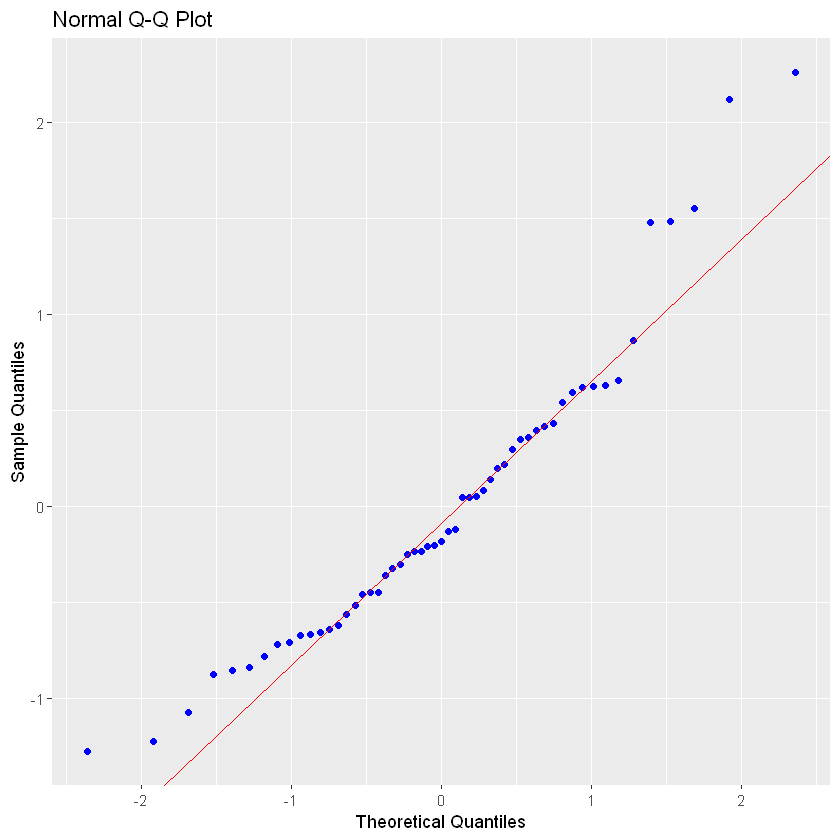

In [185]:
#h2.interaction.test(var.data,link='identity')
var.int.test <- h2.interaction.test(var.data,diagnose=TRUE)


In [186]:
#discrete.test(var.data,hyp=2,mode='exact')

# Sampling Plan

In [ ]:
# H1A
wilcoxsign_test()

# CLEAN UP EVERYTHING BELOW HERE

### Useful functions & methods

#### Determine within-subject central and peripheral QDM correlation & significance

In [201]:
# get upper half of a matrix in vector form
halfmat.v <- function(mat){
    halfmat <- c(mat[upper.tri(mat, diag = TRUE)])
    return(halfmat)
}

Additional experimental summary graphs

In [77]:
# plot the traces for the subjects individually
trace_plot <- function(datadf,type='trace',grouped=TRUE){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    if(type == 'antitrace'){
        trace_df <- trace_obtainer(datadf,'antitrace')
    } else if (type == 'difference'){
        trace_df <- trace_obtainer(datadf,'difference')
    } else {
        trace_df <- trace_obtainer(datadf)
    }
    
    
    tracedf <- gather(trace_df, key = "eccentricity",value = "trace", 2:3)
    
    if(grouped){
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace)) +
        geom_boxplot() + geom_dotplot(binaxis='y',stackdir='center',dotsize=0.5) +
        theme(legend.position = "none")
    } else {
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace, group = subject, color = subject)) +
        geom_line() + theme(legend.position = "none")
    }
    
    if(type == 'antitrace'){
        plot <- plot + ylim(0,7) + ylab("Mean Physically Maximally Distinct Stimulus Similarity")
    } else if (type == 'difference'){
        plot <- plot + ylim(-6,6) + ylab("Distinct - Identical")
    } else {
        plot <- plot + ylim(0,7) + ylab("Mean Physically Identical Stimulus Similarity")
    }
    
    return(plot)
}

## CLEAN UP NAMES

## Plot Stuff

In [462]:
# plot summary data for all the subjects individually
allsubjectsplot <- function(datadf,savestr){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects

    dir.create(paste(savestr,"Subject_Plots",sep='_')) # make a new folder to store the subject plots in

    for (subjectid in subjectlist){
        print(paste("Processing subject:",subjectid,sep=' '))
        subjectplot(datadf, subjectid,savestr)
    }
}

In [463]:
# make a plot of the key summary data for a subject - single trial type version
subjectplot <- function(datadf, subjectid,savestr){
    
    datadf = subset(datadf, subject == subjectid) # select the ID for subject of interest
    for (trial_condition in trial_types){
            subjectdf = subset(datadf, trial_type == trial_condition) # just pick one trial type at a time
    
    
        if(subjectdf$trial_type[1] != 'after_1'){
            FP = TRUE
        } else {
            FP = FALSE
        }

        # FF Matrix plot
        FFmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Central'), l2e('Central')),colors)



        # PP Matrix plot
        PPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

        # FF CMDS plot
        FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Central'), l2e('Central')))), 
                            abcolors, abcolors, l2e('Central'), l2e('Central'))



        # PP CMDS plot
        PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

        # FF nMDS plot
        FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Central'), l2e('Central')))), 
                            abcolors, abcolors, l2e('Central'), l2e('Central'))



        # PP nMDS plot
        PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

        # Similarity judgements
        simplot <- simhistplot(subjectdf)
        # Reaction times
        reactionplot <- rsplot(subjectdf)
        # summary plot
        rainplot <- rsplot_raincloud(subjectdf,'log')

        # trace plots
        traceplot <- trace_plot(subjectdf)
        antiplot <- trace_plot(subjectdf,'antitrace')
        differenceplot <- trace_plot(subjectdf,'difference')

        # asymmetry plot
        #asymplot <- asymmetry_plot(subjectdf,l2e('Central'),l2e('Central'),colors)

        # title
        if(subjectdf$noncompliant[1]){
            title <- textGrob(paste("ID:",as.character(subjectid),"|","Catch Score:",catch_score(datadf),
                              "Screen size:",round(screen_size(subjectdf)/10,1),"cm",
                              "Viewing distance:",round(view_distance(subjectdf)/10,1),"cm"),
                              gp=gpar(col="red",fontsize=35))
        } else {
            title <- textGrob(paste("ID:",as.character(subjectid),"|","Catch Score:",catch_score(datadf),
                              "Screen size:",round(screen_size(subjectdf)/10,1),"cm",
                              "Viewing distance:",round(view_distance(subjectdf)/10,1),"cm"),
                              gp=gpar(col="blue",fontsize=35))
        }
    
        if(FP){

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Central'), l2e('Peripheral')),colors)

            # FP CMDS plot
            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Central'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Central'), l2e('Peripheral'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Central'), l2e('Peripheral')))), 
                            abcolors, abcolors, l2e('Central'), l2e('Peripheral'))

            # put all the plots together
            g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, simplot,
                        FFcmds, FPcmds, PPcmds, reactionplot,
                        FFnmds, FPnmds, PPnmds, rainplot,
                        traceplot, antiplot, differenceplot, 
                        nrow = 4, ncol=4, top = title)

            exp_type <- trial_condition
            ggsave(paste(savestr,"_Subject_Plots/",exp_type,"_ID_",subjectid,"_plot.png",sep=''),
                     g, height = 40, width = 40)
        } else {
            # put all the plots together
            g <- arrangeGrob(FFmatrix, PPmatrix, simplot, traceplot,
                        FFcmds, PPcmds, reactionplot, antiplot,
                        FFnmds, PPnmds, rainplot, 
                        nrow = 3, ncol=4, top = title)

            exp_type <- trial_condition
            ggsave(paste(savestr,"_Subject_Plots/",exp_type,"_ID_",subjectid,"_plot.png",
                     sep=''),g, height = 30, width = 40)
        }
    }
}

In [218]:
if(plotsubjects){
    allsubjectsplot(datadf,savestr)
}

In [219]:
allsubjectsplot(cleandf,savestr)

[1] "Processing subject: 1"
initial  value 19.059569 
iter   5 value 9.397725
final  value 8.287254 
converged
initial  value 16.137706 
iter   5 value 11.618568
iter  10 value 11.339783
iter  10 value 11.334695
iter  10 value 11.334695
final  value 11.334695 
converged


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


initial  value 22.673820 
iter   5 value 11.036092
final  value 10.801737 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


#### New mixed trial type version analysis

In [ ]:
# matrix to define layout for the mixed trial type plot
mixed_hlay <- rbind (c(1,2,3,4,5,6),
                     c(7,8,9,10,11,12),
                     c(13,14,15,16,17,18))

In [ ]:
# names for the x axis
col_plot_list <- c('FF Matrix', 'FF nMDS', 'PP Matrix', 'PP nMDS', 'RT', 'Dissim Freq')

In [ ]:
# make a plot of the key summary data for a subject - mixed trial type version
subject_mixed_plot <- function(datadf,savestr){
    
    dir.create(paste(savestr,"Mixed_Trial_Type_Plots", sep='_'))
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    for (subjectid in subjectlist){ # do for each subject
        
        k = 0 # counter
        plot_list <- list() # list to store the plots in as we're making them
        subjectdf = subset(datadf, subject == subjectid) # select the ID for subject of interest

        for (trial_condition in trial_types){
            type_df = subset(subjectdf, trial_type == trial_condition) # just pick one trial type at a time
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(type_df, colors, l2e('Central'), l2e('Central')),colors)
            k = k + 1
            plot_list[[k]] <- as.grob(FFmatrix)
            
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(type_df,l2e('Central'), l2e('Central')))), 
                                abcolors, abcolors, l2e('Central'), l2e('Central'))
            k = k + 1
            plot_list[[k]] <- as.grob(FFnmds)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(type_df, colors, l2e('Peripheral'), l2e('Peripheral')),colors)
            k = k + 1
            plot_list[[k]] <- as.grob(PPmatrix)

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(type_df,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            k = k + 1
            plot_list[[k]] <- as.grob(PPnmds)

            # rt rain plot
            rainplot <- rsplot_raincloud(type_df)
            k = k + 1
            plot_list[[k]] <- as.grob(rainplot)
            # Similarity judgements
            simplot <- simhistplot(subjectdf)
            k = k + 1
            plot_list[[k]] <- as.grob(simplot)

        }

        # save the plots
        yaxis <- textGrob("Trial Type", gp=gpar(fontsize=30), rot=90)
        xaxis <- textGrob("", gp=gpar(fontsize=30))

        title <- textGrob(paste("ID:",subjectid,"|","Catch Score:",catch_score(subjectdf)),gp=gpar(fontsize=35))

        g <- arrangeGrob(grobs = plot_list, ncol = 6,nrow = 3,
                         layout_matrix = mixed_hlay)

        g_rowcol_names <- rbind(tableGrob(t(col_plot_list), theme = ttheme_minimal(), rows = ""),
                    cbind(tableGrob(trial_types, theme = ttheme_minimal()),
                          g, size = "last"), size = "last")


        g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
        
        savename <- paste(savestr,"_Mixed_Trial_Type_Plots/",subjectid,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 19, width = 39)
    }
}

In [ ]:
subject_mixed_plot(datadf,savestr)